In [87]:
import pickle as pkl

import lxml
import pandas as pd
import numpy as np
#import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow.keras
from tensorflow.keras.datasets import imdb

from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import PandasTools
from rdkit import Chem


from tqdm.notebook import tqdm

from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import f1_score

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from ast import literal_eval
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Activation, Dropout, Conv1D, Flatten, MaxPooling1D,\
                        AveragePooling1D, Concatenate, LeakyReLU, Embedding,\
                        GlobalMaxPooling1D,GlobalAveragePooling1D,GaussianNoise,BatchNormalization,Add
from tensorflow.keras.initializers import glorot_uniform
#from tensorflow.keras.utils.vis_utils import plot_model

import importlib
#importlib.reload(tensorflow)

from pandarallel import pandarallel
pandarallel.initialize(progress_bar = False)


INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [95]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    
    NOTE: Taken from sklearn example
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = [0,1]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    
    #ax.figsize((10, 10))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax



def get_fingerprint(smile):
    
    
    # Obtain dictionary of fingerprints and order
    try:
        bi = {}
        Chem.AllChem.GetMorganFingerprint(Chem.MolFromSmiles(smile), radius=1, bitInfo=bi)

        # Iterate over dictionary to store as pd.Series
        mol = pd.DataFrame()
        for key, value in bi.items():
            for i in range(len(value)):
                sub = pd.Series()
                sub['val'] = str(key)

                sub['order'] = value[i][0]
                sub['radius'] = value[i][1]

                mol = mol.append(sub, ignore_index=True)

        # Correctly order fingerprint
        mol = mol.sort_values(by=['order', 'radius']).reset_index(drop=True)

        # Convert ordered fingerprint into single string
        mol_string = " ".join(mol.val.tolist())
                
        return mol_string.strip()
        
    except Exception as e:
        print (e)
        return None


In [8]:
tqdm.pandas()

In [9]:
import tensorflow as tf
with tf.Session() as sess:
    devices = sess.list_devices()

In [10]:
import sys

In [11]:
!{sys.executable} -m list

/miniconda/bin/python: No module named list


### Get postive samples

In [220]:
drugbank = pkl.load(open('../data/drugbank_embds.pkl', 'rb'))

In [144]:
drugbank = pkl.load(open('../data/Positive_Samples_with_IC50_EC50_Ki_Kd_BD_Organism.pkl', 'rb'))

In [145]:
drugbank[['drug_id', 'drug_smiles', 'target_gene_sequence', 'target_id']]

,drug_id,drug_smiles,target_gene_sequence,target_id
30,DB00006,CC[C@H](C)[C@H](NC(=O)[C@H](CCC(O)=O)NC(=O)[C@...,ATGGCGCACGTCCGAGGCTTGCAGCTGCCTGGCTGCCTGGCCCTGG...,BE0000048
31,DB00006,CC[C@H](C)[C@H](NC(=O)[C@H](CCC(O)=O)NC(=O)[C@...,ATGGGGGTTCCCTTCTTCTCTTCTCTCAGATGCATGGTGGACTTAG...,BE0001075
32,DB00007,CCNC(=O)[C@@H]1CCCN1C(=O)[C@H](CCCNC(N)=N)NC(=...,ATGGCAAACAGTGCCTCTCCTGAACAGAATCAAAATCACTGTTCAG...,BE0000203
33,DB00007,CCNC(=O)[C@@H]1CCCN1C(=O)[C@H](CCCNC(N)=N)NC(=...,ATGGCTCTCATCCCAGACTTGGCCATGGAAACCTGGCTTCTCCTGG...,BE0002638
56,DB00014,CC(C)C[C@H](NC(=O)[C@@H](COC(C)(C)C)NC(=O)[C@H...,ATGAAGCAGCGGTTCTCGGCGCTGCAGCTGCTGAAGCTGCTGCTGC...,BE0000134
...,...,...,...,...
26949,DB15566,[H][C@@]12CC[C@](O)(C(=O)COC(C)=O)[C@@]1(C)C[C...,ATGAAGTGGGTAACCTTTATTTCCCTTCTTTTTCTCTTTAGCTCGG...,BE0000530
26950,DB15566,[H][C@@]12CC[C@](O)(C(=O)COC(C)=O)[C@@]1(C)C[C...,ATGGGAGAAACTGAGAAAAGAATTGAAACCCATAGAATAAGATGTC...,BE0003642
26951,DB15566,[H][C@@]12CC[C@](O)(C(=O)COC(C)=O)[C@@]1(C)C[C...,ATGGATCTTGAAGGGGACCGCAATGGAGGAGCAAAGAAGAAGAACT...,BE0001032
26952,DB15568,CN1CCC[C@H]1COC2=NC3=C(CCN(C3)C4=CC=CC5=C4C(=C...,ATGACTGAATATAAACTTGTGGTAGTTGGAGCTGGTGGCGTAGGCA...,BE0004071


In [221]:
drugbank = drugbank.rename(columns = {'target_gene_sequence': 'target_gene_code',
                                        'target_id': 'gene_id'})
#drugbank['target_amino_code'] = drugbank['target_amino'].apply(lambda x: ''.join(list(x.split('\n')[1:])))

In [147]:
drugbank['target_gene_code']

30       ATGGCGCACGTCCGAGGCTTGCAGCTGCCTGGCTGCCTGGCCCTGG...
31       ATGGGGGTTCCCTTCTTCTCTTCTCTCAGATGCATGGTGGACTTAG...
32       ATGGCAAACAGTGCCTCTCCTGAACAGAATCAAAATCACTGTTCAG...
33       ATGGCTCTCATCCCAGACTTGGCCATGGAAACCTGGCTTCTCCTGG...
56       ATGAAGCAGCGGTTCTCGGCGCTGCAGCTGCTGAAGCTGCTGCTGC...
                               ...                        
26949    ATGAAGTGGGTAACCTTTATTTCCCTTCTTTTTCTCTTTAGCTCGG...
26950    ATGGGAGAAACTGAGAAAAGAATTGAAACCCATAGAATAAGATGTC...
26951    ATGGATCTTGAAGGGGACCGCAATGGAGGAGCAAAGAAGAAGAACT...
26952    ATGACTGAATATAAACTTGTGGTAGTTGGAGCTGGTGGCGTAGGCA...
26953    ATGACTGAATATAAACTTGTGGTAGTTGGAGCTGGTGGCGTAGGCA...
Name: target_gene_code, Length: 25579, dtype: object

In [148]:
drugbank['drug_fingerprint_code'] = drugbank['drug_smiles'].progress_apply(get_fingerprint)

/miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:72: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


Python argument types in
    rdkit.Chem.rdMolDescriptors.GetMorganFingerprint(NoneType)
did not match C++ signature:
    GetMorganFingerprint(RDKit::ROMol mol, int radius, boost::python::api::object invariants=[], boost::python::api::object fromAtoms=[], bool useChirality=False, bool useBondTypes=True, bool useFeatures=False, bool useCounts=True, boost::python::api::object bitInfo=None)
Python argument types in
    rdkit.Chem.rdMolDescriptors.GetMorganFingerprint(NoneType)
did not match C++ signature:
    GetMorganFingerprint(RDKit::ROMol mol, int radius, boost::python::api::object invariants=[], boost::python::api::object fromAtoms=[], bool useChirality=False, bool useBondTypes=True, bool useFeatures=False, bool useCounts=True, boost::python::api::object bitInfo=None)
Python argument types in
    rdkit.Chem.rdMolDescriptors.GetMorganFingerprint(NoneType)
did not match C++ signature:
    GetMorganFingerprint(RDKit::ROMol mol, int radius, boost::python::api::object invariants=[], boost:

Python argument types in
    rdkit.Chem.rdMolDescriptors.GetMorganFingerprint(NoneType)
did not match C++ signature:
    GetMorganFingerprint(RDKit::ROMol mol, int radius, boost::python::api::object invariants=[], boost::python::api::object fromAtoms=[], bool useChirality=False, bool useBondTypes=True, bool useFeatures=False, bool useCounts=True, boost::python::api::object bitInfo=None)
Python argument types in
    rdkit.Chem.rdMolDescriptors.GetMorganFingerprint(NoneType)
did not match C++ signature:
    GetMorganFingerprint(RDKit::ROMol mol, int radius, boost::python::api::object invariants=[], boost::python::api::object fromAtoms=[], bool useChirality=False, bool useBondTypes=True, bool useFeatures=False, bool useCounts=True, boost::python::api::object bitInfo=None)
Python argument types in
    rdkit.Chem.rdMolDescriptors.GetMorganFingerprint(NoneType)
did not match C++ signature:
    GetMorganFingerprint(RDKit::ROMol mol, int radius, boost::python::api::object invariants=[], boost:

Python argument types in
    rdkit.Chem.rdMolDescriptors.GetMorganFingerprint(NoneType)
did not match C++ signature:
    GetMorganFingerprint(RDKit::ROMol mol, int radius, boost::python::api::object invariants=[], boost::python::api::object fromAtoms=[], bool useChirality=False, bool useBondTypes=True, bool useFeatures=False, bool useCounts=True, boost::python::api::object bitInfo=None)
Python argument types in
    rdkit.Chem.rdMolDescriptors.GetMorganFingerprint(NoneType)
did not match C++ signature:
    GetMorganFingerprint(RDKit::ROMol mol, int radius, boost::python::api::object invariants=[], boost::python::api::object fromAtoms=[], bool useChirality=False, bool useBondTypes=True, bool useFeatures=False, bool useCounts=True, boost::python::api::object bitInfo=None)
Python argument types in
    rdkit.Chem.rdMolDescriptors.GetMorganFingerprint(NoneType)
did not match C++ signature:
    GetMorganFingerprint(RDKit::ROMol mol, int radius, boost::python::api::object invariants=[], boost:

Python argument types in
    rdkit.Chem.rdMolDescriptors.GetMorganFingerprint(NoneType)
did not match C++ signature:
    GetMorganFingerprint(RDKit::ROMol mol, int radius, boost::python::api::object invariants=[], boost::python::api::object fromAtoms=[], bool useChirality=False, bool useBondTypes=True, bool useFeatures=False, bool useCounts=True, boost::python::api::object bitInfo=None)


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Python argument types in
    rdkit.Chem.rdMolDescriptors.GetMorganFingerprint(NoneType)
did not match C++ signature:
    GetMorganFingerprint(RDKit::ROMol mol, int radius, boost::python::api::object invariants=[], boost::python::api::object fromAtoms=[], bool useChirality=False, bool useBondTypes=True, bool useFeatures=False, bool useCounts=True, boost::python::api::object bitInfo=None)



In [153]:
with open('../data/Positive_Samples_with_IC50_EC50_Ki_Kd_BD_Organism_w_fp.pkl', 'wb') as f:
    pkl.dump(drugbank, f)

In [215]:
with open('../data/Positive_Samples_with_IC50_EC50_Ki_Kd_BD_Organism_w_fp.pkl', 'rb') as f:
    drugbank = pkl.load(f)

In [222]:
drugbank[~ drugbank['target_gene_code'].str.contains(r'A|T|C|G')]

KeyError: 'target_gene_code'

In [185]:
drugbank = drugbank[['drug_id', 'gene_id', 'drug_fingerprint_code', 'target_gene_code']]
drugbank = drugbank[~ drugbank['drug_fingerprint_code'].isna()]
#drugbank = drugbank.rename(columns = {'fingerprint': 'drug_fingerprint_code', 'target_id': 'gene_id'})

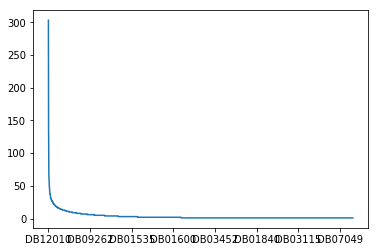

In [186]:
drugbank['drug_id'].value_counts().plot()

In [187]:
drugbank.columns

Index(['drug_id', 'gene_id', 'drug_fingerprint_code', 'target_gene_code'], dtype='object')

### Get DrugID -> Fingerprint mapping from positive samples

In [188]:
drug_map = drugbank[['drug_id', 'drug_fingerprint_code']].drop_duplicates('drug_id').set_index('drug_id')
target_map = drugbank[['gene_id', 'target_gene_code']].drop_duplicates('gene_id').set_index('gene_id')

## CHANGE NEGATIVE SAMPLE HERE

In [189]:
with open('../data/negative_samples_thrsh_13_G.pkl', 'rb') as f:
    negative_df = pkl.load(f)


In [190]:
negative_df.head()

,actions,drug_CID,drug_SID,drug_groups,drug_id,drug_inchi,drug_inchi_key,drug_iupac,drug_name,drug_smiles,drug_type,organism,target_aa_sequence,target_category,target_gene_sequence,target_id,target_name,target_uniprot_id,path,path_len
0,,445375,None,experimental,DB03645,"InChI=1S/C2H6NO5P/c4-2(3-5)1-9(6,7)8/h5H,1H2,(...",LDKRAXXVBWHMRH-UHFFFAOYSA-N,[(hydroxycarbamoyl)methyl]phosphonic acid,Phosphonoacetohydroxamic Acid,ONC(=O)CP(O)(O)=O,small molecule,T3D,MSSMILTQFGPFIESISGITDQSNDVFEDAAKAFSMFTRSDVYKAL...,target,,BE0004792,RNA-directed RNA polymerase lambda-3,P0CK31,"[DB03645, BE0004460, DB01819, BE0002562, DB034...",13
1,,445375,None,experimental,DB03645,"InChI=1S/C2H6NO5P/c4-2(3-5)1-9(6,7)8/h5H,1H2,(...",LDKRAXXVBWHMRH-UHFFFAOYSA-N,[(hydroxycarbamoyl)methyl]phosphonic acid,Phosphonoacetohydroxamic Acid,ONC(=O)CP(O)(O)=O,small molecule,Mycobacterium tuberculosis H37Rv,MSDFDTERVSRAVAAALVGPGGVALVVKVFAGLPGVIHTPARRGFF...,target,ATGTCTGATTTCGATACCGAGCGAGTGAGCCGCGCCGTCGCGGCCG...,BE0004223,Uncharacterized protein,O06796,"[DB03645, BE0004460, DB01819, BE0002562, DB034...",13
2,,445375,None,experimental,DB03645,"InChI=1S/C2H6NO5P/c4-2(3-5)1-9(6,7)8/h5H,1H2,(...",LDKRAXXVBWHMRH-UHFFFAOYSA-N,[(hydroxycarbamoyl)methyl]phosphonic acid,Phosphonoacetohydroxamic Acid,ONC(=O)CP(O)(O)=O,small molecule,Humans,MESPSAPPHRWCIPWQRLLLTASLLTFWNPPTTAKLTIESTPFNVA...,target,ATGGAGTCTCCCTCGGCCCCTCCCCACAGATGGTGCATCCCCTGGC...,BE0004224,Carcinoembryonic antigen-related cell adhesion...,P06731,"[DB03645, BE0004460, DB01819, BE0002562, DB034...",13
3,,445375,None,experimental,DB03645,"InChI=1S/C2H6NO5P/c4-2(3-5)1-9(6,7)8/h5H,1H2,(...",LDKRAXXVBWHMRH-UHFFFAOYSA-N,[(hydroxycarbamoyl)methyl]phosphonic acid,Phosphonoacetohydroxamic Acid,ONC(=O)CP(O)(O)=O,small molecule,Escherichia coli,MKKLAIMAAASMVFAVSSAHAGFTPSGTTGTTKLTVTEECQVRVGD...,target,ATGAGGGAGCGATATCTGTATCTTGCTGACACCCCTCAGGGGATAC...,BE0004225,Afimbrial adhesin AFA-III,Q57254,"[DB03645, BE0004460, DB01819, BE0002562, DB034...",13
4,,445375,None,experimental,DB03645,"InChI=1S/C2H6NO5P/c4-2(3-5)1-9(6,7)8/h5H,1H2,(...",LDKRAXXVBWHMRH-UHFFFAOYSA-N,[(hydroxycarbamoyl)methyl]phosphonic acid,Phosphonoacetohydroxamic Acid,ONC(=O)CP(O)(O)=O,small molecule,Mycobacterium tuberculosis,MSPAPVQVMGVLNVTDDSFSDGGCYLDLDDAVKHGLAMAAAGAGIV...,target,GTGAGTCCGGCGCCCGTGCAGGTGATGGGGGTTCTAAACGTCACGG...,BE0001974,Dihydropteroate synthase 1,P9WND1,"[DB03645, BE0004460, DB01819, BE0003655, DB001...",13


In [191]:
negative_df = negative_df.rename(columns = {'target_id': 'gene_id'})

In [192]:
#negative_df = negative_df[['node_0','node_1','shortest_path']] 
#negative_df = negative_df.rename(columns = {'node_0': 'drug_id', 'node_1': 'gene_id'})
#negative_df = negative_df[negative_df['drug_id'].str.contains('DB') & negative_df['gene_id'].str.contains('BE')]

## END CHANGE NEGATIVE SAMPLE HERE

In [193]:
negative_df = pd.merge(negative_df, drug_map, left_on = 'drug_id', right_index = True, how = 'left')
negative_df = pd.merge(negative_df, target_map, left_on = 'gene_id', right_index = True, how = 'left')

In [194]:
negative_df.head()

,actions,drug_CID,drug_SID,drug_groups,drug_id,drug_inchi,drug_inchi_key,drug_iupac,drug_name,drug_smiles,...,target_aa_sequence,target_category,target_gene_sequence,gene_id,target_name,target_uniprot_id,path,path_len,drug_fingerprint_code,target_gene_code
0,,445375,None,experimental,DB03645,"InChI=1S/C2H6NO5P/c4-2(3-5)1-9(6,7)8/h5H,1H2,(...",LDKRAXXVBWHMRH-UHFFFAOYSA-N,[(hydroxycarbamoyl)methyl]phosphonic acid,Phosphonoacetohydroxamic Acid,ONC(=O)CP(O)(O)=O,...,MSSMILTQFGPFIESISGITDQSNDVFEDAAKAFSMFTRSDVYKAL...,target,,BE0004792,RNA-directed RNA polymerase lambda-3,P0CK31,"[DB03645, BE0004460, DB01819, BE0002562, DB034...",13,864662311 2328755054 847961216 2186243679 2246...,
1,,445375,None,experimental,DB03645,"InChI=1S/C2H6NO5P/c4-2(3-5)1-9(6,7)8/h5H,1H2,(...",LDKRAXXVBWHMRH-UHFFFAOYSA-N,[(hydroxycarbamoyl)methyl]phosphonic acid,Phosphonoacetohydroxamic Acid,ONC(=O)CP(O)(O)=O,...,MSDFDTERVSRAVAAALVGPGGVALVVKVFAGLPGVIHTPARRGFF...,target,ATGTCTGATTTCGATACCGAGCGAGTGAGCCGCGCCGTCGCGGCCG...,BE0004223,Uncharacterized protein,O06796,"[DB03645, BE0004460, DB01819, BE0002562, DB034...",13,864662311 2328755054 847961216 2186243679 2246...,ATGTCTGATTTCGATACCGAGCGAGTGAGCCGCGCCGTCGCGGCCG...
2,,445375,None,experimental,DB03645,"InChI=1S/C2H6NO5P/c4-2(3-5)1-9(6,7)8/h5H,1H2,(...",LDKRAXXVBWHMRH-UHFFFAOYSA-N,[(hydroxycarbamoyl)methyl]phosphonic acid,Phosphonoacetohydroxamic Acid,ONC(=O)CP(O)(O)=O,...,MESPSAPPHRWCIPWQRLLLTASLLTFWNPPTTAKLTIESTPFNVA...,target,ATGGAGTCTCCCTCGGCCCCTCCCCACAGATGGTGCATCCCCTGGC...,BE0004224,Carcinoembryonic antigen-related cell adhesion...,P06731,"[DB03645, BE0004460, DB01819, BE0002562, DB034...",13,864662311 2328755054 847961216 2186243679 2246...,ATGGAGTCTCCCTCGGCCCCTCCCCACAGATGGTGCATCCCCTGGC...
3,,445375,None,experimental,DB03645,"InChI=1S/C2H6NO5P/c4-2(3-5)1-9(6,7)8/h5H,1H2,(...",LDKRAXXVBWHMRH-UHFFFAOYSA-N,[(hydroxycarbamoyl)methyl]phosphonic acid,Phosphonoacetohydroxamic Acid,ONC(=O)CP(O)(O)=O,...,MKKLAIMAAASMVFAVSSAHAGFTPSGTTGTTKLTVTEECQVRVGD...,target,ATGAGGGAGCGATATCTGTATCTTGCTGACACCCCTCAGGGGATAC...,BE0004225,Afimbrial adhesin AFA-III,Q57254,"[DB03645, BE0004460, DB01819, BE0002562, DB034...",13,864662311 2328755054 847961216 2186243679 2246...,ATGAGGGAGCGATATCTGTATCTTGCTGACACCCCTCAGGGGATAC...
4,,445375,None,experimental,DB03645,"InChI=1S/C2H6NO5P/c4-2(3-5)1-9(6,7)8/h5H,1H2,(...",LDKRAXXVBWHMRH-UHFFFAOYSA-N,[(hydroxycarbamoyl)methyl]phosphonic acid,Phosphonoacetohydroxamic Acid,ONC(=O)CP(O)(O)=O,...,MSPAPVQVMGVLNVTDDSFSDGGCYLDLDDAVKHGLAMAAAGAGIV...,target,GTGAGTCCGGCGCCCGTGCAGGTGATGGGGGTTCTAAACGTCACGG...,BE0001974,Dihydropteroate synthase 1,P9WND1,"[DB03645, BE0004460, DB01819, BE0003655, DB001...",13,864662311 2328755054 847961216 2186243679 2246...,GTGAGTCCGGCGCCCGTGCAGGTGATGGGGGTTCTAAACGTCACGG...


#### Note: Around 13% of negative samples don't match a drug id. Since the number is small, we ignore it for now

In [195]:
len(negative_df[(negative_df['target_gene_code'].isna()) |
                (negative_df['drug_fingerprint_code'].isna())])/len(negative_df)

negative_df = negative_df[(~ negative_df['target_gene_code'].isna()) &
                (~ negative_df['drug_fingerprint_code'].isna())]

In [196]:
len(negative_df)

38862

In [197]:
len(drugbank)

25494

In [198]:
negative_df['Y'] = 0
drugbank['Y'] = 1
drugbank = drugbank.append(negative_df.sample(frac = 1)) ## NUMBER OF NEGATIVE SAMPLES TO PICK
#drugbank = drugbank.drop('shortest_path', axis = 1)

In [199]:
drugbank.tail()

,drug_id,gene_id,drug_fingerprint_code,target_gene_code,Y,actions,drug_CID,drug_SID,drug_groups,drug_inchi,...,drug_smiles,drug_type,organism,target_aa_sequence,target_category,target_gene_sequence,target_name,target_uniprot_id,path,path_len
31912,DB04610,BE0001498,2246728737 1861965050 2976816164 1189346528 22...,ATGAGTGAAGTACTGATTACCGGCCTGAGGACGCGGGCCGTCAATG...,0,,135509072,None,experimental,InChI=1S/C16H19N5O2/c1-16(8-7-10-5-3-2-4-6-10)...,...,C[C@@]1(CCC2=CC=CC=C2)NC2=C(N=C1CO)C(=O)NC(N)=N2,small molecule,Pseudomonas putida,MSEVLITGLRTRAVNVPLAYPVHTAVGTVGTAPLVLIDLATSAGVV...,target,ATGAGTGAAGTACTGATTACCGGCCTGAGGACGCGGGCCGTCAATG...,Mandelate racemase,P11444,"[BE0001498, DB02280, BE0001286, DB01987, BE000...",13.0
718,DB04685,BE0003730,2976033787 3145161786 882399112 4041152544 296...,ATGCTGCTCGGGTGGGCGTCCCTGCTGCTGTGCGCGTTCCGCCTGC...,0,,[4369390.0],[104073833.0],experimental,InChI=1S/C28H25FN2O4/c29-23-18-26(31-17-16-25(...,...,[H][C@]1(F)C[C@@]([H])(O[C@]1([H])COC(C1=CC=CC...,small molecule,Humans,MLLGWASLLLCAFRLPLAAVGPAATPAQDKAGQPPTAAAAAQPRRR...,target,ATGCTGCTCGGGTGGGCGTCCCTGCTGCTGTGCGCGTTCCGCCTGC...,A disintegrin and metalloproteinase with throm...,Q9UNA0,"[DB04685, BE0001205, DB03413, BE0001364, DB023...",13.0
38241,DB07986,BE0001940,864662311 1533864325 2246699815 4278941385 864...,ATGAACATGAAAAAACTGGCTACCCTGGTTTCCGCTGTTGCGCTAA...,0,,1948,None,experimental,"InChI=1S/C19H22N2O4S/c22-19(23)14-20-26(24,25)...",...,OC(=O)CNS(=O)(=O)C1=CC=C(C=C1)N1CCC(CC1)C1=CC=...,small molecule,Escherichia coli (strain K12),MNMKKLATLVSAVALSATVSANAMAKDTIALVVSTLNNPFFVSLKD...,target,ATGAACATGAAAAAACTGGCTACCCTGGTTTCCGCTGTTGCGCTAA...,D-ribose-binding periplasmic protein,P02925,"[BE0001940, DB04286, BE0001942, DB04352, BE000...",13.0
26692,DB03705,BE0004265,2246728737 3824063894 847961216 1965692378 321...,,0,,135509070,None,experimental,InChI=1S/C5H7N5O3/c1-7-3-2(10(12)13)4(11)9-5(6...,...,CNC1=C(C(=O)NC(N)=N1)[N+]([O-])=O,small molecule,Humans,MAWTPLFLFLLTCCPGGSNSQTVVTQEPSLTVSPGGTVTLTCASST...,target,,Ig lambda chain V region 4A,P04211,"[BE0004265, DB08273, BE0004264, DB08294, BE000...",15.0
10046,DB04433,BE0004306,2976033787 2617658656 2968968094 2117068077 29...,ATGCCTGAGAATACTGCAATGGCGGCGCTTTTGCCGGAAGAGTCCC...,0,,449095,None,experimental,InChI=1S/C11H19N5O2/c12-11(13)14-5-1-3-7-10(18...,...,[H][C@@]12CCCN1C(=O)[C@H](CCCNC(N)=N)NC2=O,small molecule,Acidithiobacillus ferrooxidans (strain ATCC 23...,MPENTAMAALLPEESLFFRELVKQWRAQDSYGTWEKKSDMELLAPY...,target,ATGCCTGAGAATACTGCAATGGCGGCGCTTTTGCCGGAAGAGTCCC...,Putative uncharacterized protein,B7JA91,"[DB04433, BE0001584, DB02813, BE0001153, DB002...",13.0


In [200]:
drugbank = drugbank[['drug_id', 'gene_id', 'drug_fingerprint_code', 'target_gene_code', 'Y']]

In [206]:
drugbank[drugbank['target_gene_code'].apply(type) == float]

,drug_id,gene_id,drug_fingerprint_code,target_gene_code,Y


In [207]:
drugbank[drugbank['drug_fingerprint_code'].apply(type) == float]

,drug_id,gene_id,drug_fingerprint_code,target_gene_code,Y


In [212]:
drugbank = drugbank[~ drugbank['target_gene_code'].str.contains(r'A|T|C|G')]

#### The dataset is clean and balanced

In [213]:
drugbank['Y'].value_counts()/len(drugbank)

0    0.856161
1    0.143839
Name: Y, dtype: float64

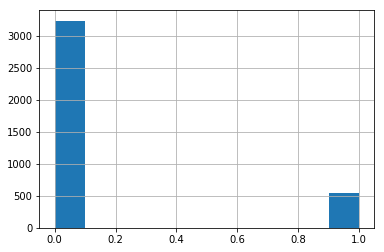

In [214]:
drugbank['Y'].hist()

#### Preprocessing fingerprints to feed to CNN

In [205]:
label_encoder = LabelEncoder()
label_encoder.fit(list(drugbank['target_gene_code'].iloc[0]))

#with open('../data/gene_encoder.pkl', 'wb') as f:
#    pkl.dump(label_encoder, f)
    
gene_chars = set(list(drugbank['target_gene_code'].iloc[0]))

drugbank['target_gene_encoded'] = drugbank['target_gene_code'].progress_apply(\
                                   lambda x: label_encoder.transform([i for i in list(x) if i in gene_chars]))
drugbank['drug_fingerprint_encoded'] = drugbank['drug_fingerprint_code'].progress_apply(lambda x: [int(i) for i in x.replace(' ', '')])

TypeError: Cannot cast array data from dtype('float64') to dtype('<U32') according to the rule 'safe'

In [38]:
drugbank.head()

,drug_id,gene_id,drug_fingerprint_code,target_gene_code,Y,target_gene_encoded,drug_fingerprint_encoded
0,DB03313,BE0001349,2246728737 3545365497 2246699815 2664995851 86...,ATGGTCTCAGGAACGGTGGGCAGAGGTACGGCGCTGGGCGCGGTGC...,1,"[0, 3, 2, 2, 3, 1, 3, 1, 0, 2, 2, 0, 0, 1, 2, ...","[2, 2, 4, 6, 7, 2, 8, 7, 3, 7, 3, 5, 4, 5, 3, ..."
1,DB03313,BE0004335,2246728737 3545365497 2246699815 2664995851 86...,ATGCAAAATCAATTAAATGAATTAAAACGAAAAATGCTGGAATTTT...,1,"[0, 3, 2, 1, 0, 0, 0, 0, 3, 1, 0, 0, 3, 3, 0, ...","[2, 2, 4, 6, 7, 2, 8, 7, 3, 7, 3, 5, 4, 5, 3, ..."
2,DB03313,BE0004290,2246728737 3545365497 2246699815 2664995851 86...,ATGAACAAACCAACGATTCTGCGCCTAATCAAGTATCTGAGCATTA...,1,"[0, 3, 2, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 2, ...","[2, 2, 4, 6, 7, 2, 8, 7, 3, 7, 3, 5, 4, 5, 3, ..."
3,DB03313,BE0003624,2246728737 3545365497 2246699815 2664995851 86...,ATGAGACTGATTTGTATGAGAAAATTTAACAGCCATTCGATTCCGA...,1,"[0, 3, 2, 0, 2, 0, 1, 3, 2, 0, 3, 3, 3, 2, 3, ...","[2, 2, 4, 6, 7, 2, 8, 7, 3, 7, 3, 5, 4, 5, 3, ..."
4,DB03313,BE0004644,2246728737 3545365497 2246699815 2664995851 86...,ATGAAATTAGATAAATTATTTGAGAAATTTCTTTCTCTTTTTAAAA...,1,"[0, 3, 2, 0, 0, 0, 3, 3, 0, 2, 0, 3, 0, 0, 0, ...","[2, 2, 4, 6, 7, 2, 8, 7, 3, 7, 3, 5, 4, 5, 3, ..."


#### Calculate length mismatches and pad

In [39]:
drugbank['target_gene_encoded_len'] = drugbank['target_gene_encoded']\
                                    .apply(lambda x: len(x))
drugbank['drug_fingerprint_encoded_len'] = drugbank['drug_fingerprint_encoded']\
                                    .apply(lambda x: len(x))

In [40]:
drugbank['mismatch'] = drugbank[['target_gene_encoded', 'drug_fingerprint_encoded']]\
                        .apply(lambda x: len(x['target_gene_encoded']) - len(x['drug_fingerprint_encoded']), axis = 1)

## Most Genes are longer than fingerprints

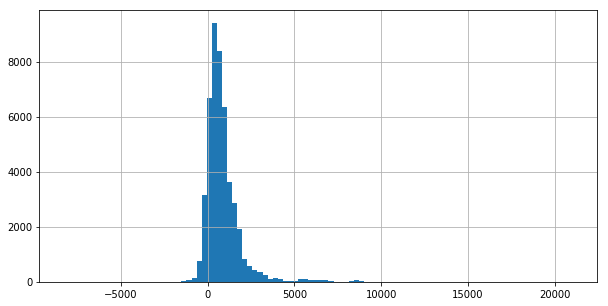

In [41]:
drugbank['mismatch'].hist(bins = 100, figsize = (10, 5))

In [42]:
print('95 percent of the mismatches are of the range %f to %f' % (max(drugbank['mismatch'].value_counts()) - np.std(drugbank['mismatch'].value_counts()),
                                                           max(drugbank['mismatch'].value_counts()) + np.std(drugbank['mismatch'].value_counts())))

95 percent of the mismatches are of the range 59.245281 to 82.754719


In [43]:
max_target_gene_encoded_len = max(drugbank['target_gene_encoded_len'])
max_drug_fingerprint_encoded_len = max(drugbank['drug_fingerprint_encoded_len'])

In [44]:
drugbank['target_gene_encoded_mismatch'] = max_target_gene_encoded_len - drugbank['target_gene_encoded_len']

In [45]:
drugbank['drug_fingerprint_encoded_mismatch'] = max_drug_fingerprint_encoded_len - drugbank['drug_fingerprint_encoded_len'] 

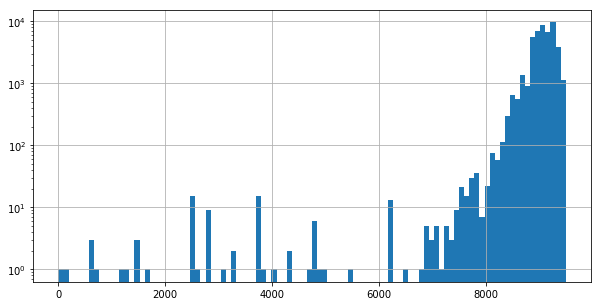

In [46]:
drugbank['drug_fingerprint_encoded_mismatch'].hist(bins = 100, figsize = (10, 5), log = True)

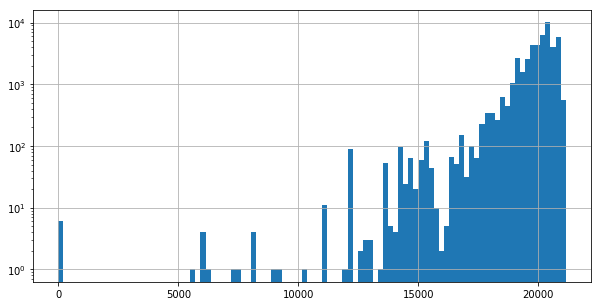

In [47]:
drugbank['target_gene_encoded_mismatch'].hist(bins = 100, figsize = (10, 5), log = True)

#### There appears to be quite large intracolumn mismatches in length. Unsure how to deal with it now. Current strategy is to pad the inputs and model it

In [48]:
drugbank['target_gene_encoded_padded'] = drugbank[['target_gene_encoded','target_gene_encoded_mismatch']]\
                                         .progress_apply(lambda x: ['-1' for i in range(int(x['target_gene_encoded_mismatch']/2))] +   
                                                        list(x['target_gene_encoded']) +
                                                        ['-1' for i in range (int(x['target_gene_encoded_mismatch']/2))]
                                                        , axis = 1)
drugbank['target_gene_encoded_padded'] = drugbank['target_gene_encoded_padded'].apply(lambda x: x + ['-1'] if len(x) < max_target_gene_encoded_len else x)

In [49]:
drugbank['drug_fingerprint_encoded_padded'] = drugbank[['drug_fingerprint_encoded','drug_fingerprint_encoded_mismatch']]\
                                         .progress_apply(lambda x: ['-1' for i in range(int(x['drug_fingerprint_encoded_mismatch']/2))] +   
                                                        list(x['drug_fingerprint_encoded']) +
                                                        ['-1' for i in range (int(x['drug_fingerprint_encoded_mismatch']/2))]
                                                        , axis = 1)

drugbank['drug_fingerprint_encoded_padded'] = drugbank['drug_fingerprint_encoded_padded'].apply(lambda x: x + ['-1'] if len(x) < max_drug_fingerprint_encoded_len else x)

In [50]:
drugbank.sort_values('Y')

,drug_id,gene_id,drug_fingerprint_code,target_gene_code,Y,target_gene_encoded,drug_fingerprint_encoded,target_gene_encoded_len,drug_fingerprint_encoded_len,mismatch,target_gene_encoded_mismatch,drug_fingerprint_encoded_mismatch,target_gene_encoded_padded,drug_fingerprint_encoded_padded
3273,DB07160,BE0004382,2246728737 3542456614 2245384272 1506563592 22...,ATGAAAGCTCAGGGGGAAACCGAGGAGTCAGAAAAGCTGAGTAAGA...,0,"[0, 3, 2, 0, 0, 0, 2, 1, 3, 1, 0, 2, 2, 2, 2, ...","[2, 2, 4, 6, 7, 2, 8, 7, 3, 7, 3, 5, 4, 2, 4, ...",4746,373,4373,16476,9128,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."
22574,DB07026,BE0003348,2968968094 2811394787 2976033787 1759553307 29...,ATGCATTTAAAAATTGTATGTCTGAGTGATGAGGTCAGAGAAATGT...,0,"[0, 3, 2, 1, 0, 3, 3, 3, 0, 0, 0, 0, 0, 3, 3, ...","[2, 9, 6, 8, 9, 6, 8, 0, 9, 4, 2, 8, 1, 1, 3, ...",522,541,-19,20700,8960,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."
24553,DB07610,BE0003310,3218693969 98513984 3218693969 98513984 321869...,ATGAGAAACAGACGTGAGGTTTCAAAATTGCTTTCAGAAAGGGTGT...,0,"[0, 3, 2, 0, 2, 0, 0, 0, 1, 0, 2, 0, 1, 2, 3, ...","[3, 2, 1, 8, 6, 9, 3, 9, 6, 9, 9, 8, 5, 1, 3, ...",2307,226,2081,18915,9275,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."
9096,DB02798,BE0001942,2246728737 3826141526 984189120 544338626 8649...,ATGAAAAAACACGGTATACTGAACAGCCATCTTGCCAAGATTTTAG...,0,"[0, 3, 2, 0, 0, 0, 0, 0, 0, 1, 0, 1, 2, 2, 3, ...","[2, 2, 4, 6, 7, 2, 8, 7, 3, 7, 3, 8, 2, 6, 1, ...",396,443,-47,20826,9058,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."
7701,DB03138,BE0003968,864942795 980083357 3858440414 111128113 86494...,ATGGAGCTGGCACTGCGGCGCTCTCCCGTCCCGCGGTGGTTGCTGC...,0,"[0, 3, 2, 2, 0, 2, 1, 3, 2, 2, 1, 0, 1, 3, 2, ...","[8, 6, 4, 9, 4, 2, 7, 9, 5, 9, 8, 0, 0, 8, 3, ...",1359,91,1268,19863,9410,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9379,DB08280,BE0000329,2246728737 3537123720 2245277810 2442433719 22...,ATGGCTTTTATGAAAAAATATCTCCTCCCCATTCTGGGGCTCTTCA...,1,"[0, 3, 2, 2, 1, 3, 3, 3, 3, 0, 3, 2, 0, 0, 0, ...","[2, 2, 4, 6, 7, 2, 8, 7, 3, 7, 3, 5, 3, 7, 1, ...",879,544,335,20343,8957,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."
9378,DB04113,BE0000465,2968968094 2142032900 2968968094 2142032900 29...,ATGAGCACAGCAGGAAAAGTAATCAAATGCAAAGCAGCTGTGCTAT...,1,"[0, 3, 2, 0, 2, 1, 0, 1, 0, 2, 1, 0, 2, 2, 0, ...","[2, 9, 6, 8, 9, 6, 8, 0, 9, 4, 2, 1, 4, 2, 0, ...",1128,158,970,20094,9343,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."
9377,DB08198,BE0001852,2246728737 422715066 3217380708 4247217172 321...,ATGGCGTCGCAGCCAAATTCGTCTGCGAAGAAGAAAGAGGAGAAGG...,1,"[0, 3, 2, 2, 1, 2, 3, 1, 2, 1, 0, 2, 1, 1, 0, ...","[2, 2, 4, 6, 7, 2, 8, 7, 3, 7, 4, 2, 2, 7, 1, ...",3171,460,2711,18051,9041,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."
9388,DB09076,BE0000560,2968968094 2119439498 2968968094 1653789098 21...,ATGAATAACTCAACAAACTCCTCTAACAATAGCCTGGCTCTTACAA...,1,"[0, 3, 2, 0, 0, 3, 0, 0, 1, 3, 1, 0, 0, 1, 0, ...","[2, 9, 6, 8, 9, 6, 8, 0, 9, 4, 2, 1, 1, 9, 4, ...",1401,612,789,19821,8889,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."


In [51]:
drugbank.sort_values('drug_id').reset_index(drop=True).to_csv('../data/intermediate/interactions_preprocessed_OG.csv', index = False)